### Implementación de la red neuronal con preprocesamiento GuidedFilter de imágenes suavizadas

2025-05-06 13:20:12.973949: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 13:20:12.976623: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-06 13:20:13.021832: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-06 13:20:13.021876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-06 13:20:13.022909: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to


Epoch 1: LearningRateScheduler setting learning rate to 0.09000000357627869.
Epoch 1/5
243/243 [==============================] - 414s 2s/step - loss: 0.6146 - accuracy: 0.6855 - val_loss: 0.7948 - val_accuracy: 0.3703 - lr: 0.0900

Epoch 2: LearningRateScheduler setting learning rate to 0.09000000357627869.
Epoch 2/5
243/243 [==============================] - 420s 2s/step - loss: 0.6168 - accuracy: 0.6889 - val_loss: 0.7902 - val_accuracy: 0.3703 - lr: 0.0900

Epoch 3: LearningRateScheduler setting learning rate to 0.09000000357627869.
Epoch 3/5
243/243 [==============================] - 416s 2s/step - loss: 0.6199 - accuracy: 0.6907 - val_loss: 0.8387 - val_accuracy: 0.3703 - lr: 0.0900

Epoch 4: LearningRateScheduler setting learning rate to 0.06300000250339508.
Epoch 4/5
243/243 [==============================] - 410s 2s/step - loss: 0.6216 - accuracy: 0.6835 - val_loss: 0.8032 - val_accuracy: 0.3703 - lr: 0.0630

Epoch 5: LearningRateScheduler setting learning rate to 0.063000001

/home/ale/Documentos/PID/genero_manos/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


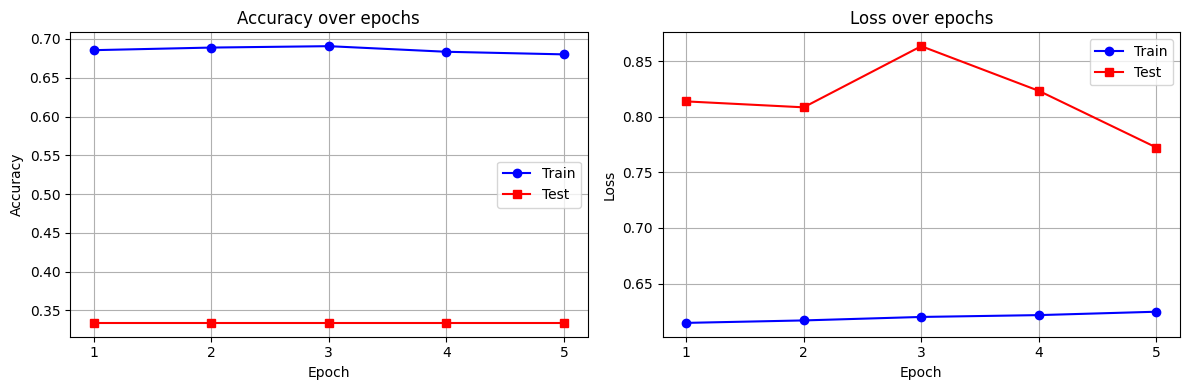

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers.legacy import SGD

# ============================= Configuración general =============================
IMG_SIZE    = (224, 224)
BATCH_SIZE  = 32

# Preprocesamiento Guided Filter
RADIUS = 10      # radio del filtro guiado
EPS    = 0.01    # epsilon de regularización

csv_path   = "../../dataset/HandInfo.csv"
image_root = "../../dataset/image"

# ============================= Leer etiquetas ====================================
df = pd.read_csv(csv_path)
df["label"] = df["gender"].map({"male":0, "female":1})
NUM_CLASSES = df["label"].nunique()

# ============================== Normalización Z-score ==============================
def z_score_normalization(image: np.ndarray) -> np.ndarray:
    mean = image.mean()
    std  = image.std()
    return (image - mean) / (std + 1e-7)

# ========================= Funciones de preprocesado =============================
def preprocess_image_guided(path_bytes: bytes) -> np.ndarray:
    path = path_bytes.decode("utf-8")
    img  = cv2.imread(path).astype(np.float32)
    if img is None:
        return np.zeros((*IMG_SIZE,3), dtype=np.float32)
    img = cv2.resize(img, IMG_SIZE)
    gf  = cv2.ximgproc.createGuidedFilter(guide=img, radius=RADIUS, eps=EPS)
    low = gf.filter(img)
    return z_score_normalization(low)

def tf_preprocess(path, label):
    out = tf.numpy_function(preprocess_image_guided, [path], tf.float32)
    out.set_shape((*IMG_SIZE,3))
    return out, label

# ========================= Crear tf.data.Dataset =================================
def create_dataset(split: str):
    folder = os.path.join(image_root, split)
    files  = set(os.listdir(folder))
    subdf  = df[df["imageName"].isin(files)].sort_values("imageName")
    paths  = [os.path.join(folder, fn) for fn in subdf["imageName"]]
    labels = subdf["label"].values
    ds     = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds     = ds.map(tf_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if split == "train":
        ds = ds.shuffle(1000)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = create_dataset("train")
val_ds   = create_dataset("val")
test_ds  = create_dataset("test")

# ========================= Definición de la ResNet‐light ===========================
def residual_block(x, filters, downsample=False):
    identity = x
    stride   = 2 if downsample else 1

    x = layers.Conv2D(filters, 3, strides=stride, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if downsample or identity.shape[-1] != filters:
        identity = layers.Conv2D(filters, 1, strides=stride, use_bias=False)(identity)
        identity = layers.BatchNormalization()(identity)

    x = layers.Add()([x, identity])
    return layers.ReLU()(x)

def build_resnet(input_shape=(224,224,3), num_classes=2):
    inp = layers.Input(shape=input_shape)
    x   = layers.Conv2D(64, 7, strides=2, padding="same", use_bias=False)(inp)
    x   = layers.BatchNormalization()(x)
    x   = layers.ReLU()(x)
    x   = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    for _ in range(2):
        x = residual_block(x, 64)
    for i in range(3):
        x = residual_block(x, 128, downsample=(i==0))
    for i in range(4):
        x = residual_block(x, 256, downsample=(i==0))
    x   = layers.GlobalAveragePooling2D()(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inp, out)

# ============================== Compilación =======================================
model = build_resnet(num_classes=NUM_CLASSES)
model.compile(
    optimizer=SGD(learning_rate=0.09, momentum=0.9, decay=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# ================= Callback para test cada época =================================
class TestCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_ds):
        super().__init__()
        self.test_ds = test_ds
        self.test_losses, self.test_accuracies = [], []
    def on_epoch_end(self, epoch, logs=None):
        loss, acc = self.model.evaluate(self.test_ds, verbose=0)
        self.test_losses.append(loss)
        self.test_accuracies.append(acc)
        print(f"  → Test loss: {loss:.4f} — Test acc: {acc:.4f}")

test_cb = TestCallback(test_ds)

# ================= Scheduler de LR para 5 épocas =====================
def lr_schedule(epoch, lr):
    # Reduce LR al comienzo de la 4ª época
    if epoch == 3:
        return lr * 0.7
    return lr

lr_cb = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)

# ============================= Entrenamiento =====================================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[lr_cb, test_cb],
    verbose=1
)

model.save("guided_model.h5")

# ================== Plot de Train vs Test (accuracy y loss) =======================
epochs = range(1, len(history.history["accuracy"]) + 1)
train_acc = history.history["accuracy"]
test_acc  = test_cb.test_accuracies
train_loss= history.history["loss"]
test_loss = test_cb.test_losses

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# Accuracy
ax1.plot(epochs, train_acc, marker='o', color='blue', label='Train')
ax1.plot(epochs, test_acc,  marker='s', color='red',  label='Test')
ax1.set_title("Accuracy over epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_xticks(epochs)
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(epochs, train_loss, marker='o', color='blue', label='Train')
ax2.plot(epochs, test_loss,  marker='s', color='red',  label='Test')
ax2.set_title("Loss over epochs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_xticks(epochs)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()
